# synpuf disclosure risk

Compare synthetic PUFs trained from a 10% sample, both to the training set and a 10% holdout. Synthetic file (1) is from synthimpute random forests; (2) is from the synthpop R package.

## Setup

### Imports

In [1]:
import pandas as pd
import numpy as np
import synthimpute as si
from scipy import stats

import matplotlib as mpl
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter

### Graphing

In [2]:
!wget https://github.com/MaxGhenis/random/raw/master/Roboto-Regular.ttf -P /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf
mpl.font_manager._rebuild()

--2018-12-19 22:18:31--  https://github.com/MaxGhenis/random/raw/master/Roboto-Regular.ttf
Resolving github.com (github.com)... 192.30.255.113, 192.30.255.112
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MaxGhenis/random/master/Roboto-Regular.ttf [following]
--2018-12-19 22:18:32--  https://raw.githubusercontent.com/MaxGhenis/random/master/Roboto-Regular.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.40.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.40.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 145348 (142K) [application/octet-stream]
/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf: No such file or directory/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/Roboto-Regular.ttf: No such file or directory

Cannot write to '/usr/local

In [3]:
sns.set_style('white')
DPI = 200
mpl.rc('savefig', dpi=DPI)
mpl.rcParams['figure.dpi'] = DPI
mpl.rcParams['figure.figsize'] = 6.4, 4.8  # Default.
mpl.rcParams['font.sans-serif'] = 'Roboto'
mpl.rcParams['font.family'] = 'sans-serif'

# Set title text color to dark gray (https://material.io/color) not black.
TITLE_COLOR = '#212121'
mpl.rcParams['text.color'] = TITLE_COLOR

# Axis titles and tick marks are medium gray.
AXIS_COLOR = '#757575'
mpl.rcParams['axes.labelcolor'] = AXIS_COLOR
mpl.rcParams['xtick.color'] = AXIS_COLOR
mpl.rcParams['ytick.color'] = AXIS_COLOR

### Load data

In [4]:
synth = pd.read_csv('~/Downloads/puf_synth_10p_sample.csv')
synthpop = pd.read_csv('~/Downloads/synthpop_samp.csv')
train = pd.read_csv('~/Downloads/puf_10p_sample_train.csv')
test = pd.read_csv('~/Downloads/puf_10p_sample_test.csv')

## Preprocessing

Drop calculated features used as seeds, and drop s006.

In [5]:
synth.drop(['E00100', 'E09600', 'S006'], axis=1, inplace=True)
train.drop(['E00100', 'E09600', 'S006'], axis=1, inplace=True)
test.drop(['E00100', 'E09600', 'S006'], axis=1, inplace=True)
synthpop = synthpop[synth.columns]

In [6]:
synthpop = synthpop[synth.columns]

Check pending https://github.com/MaxGhenis/synthimpute/issues/8.

In [7]:
synth.reset_index(drop=True, inplace=True)
synthpop.reset_index(drop=True, inplace=True)
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [8]:
# TODO: Do this in the file creation.
def add_subtracted_features(df):
    df['E00600'] = df.E00650 + df.e00600_minus_e00650
    df['E01500'] = df.E01700 + df.e01500_minus_e01700
    df.drop(['e00600_minus_e00650', 'e01500_minus_e01700'], axis=1, inplace=True)
    
add_subtracted_features(train)
add_subtracted_features(test)

## Comparisons

Compare nearest standardized Euclidean distance.

In [9]:
BLOCKS = ['MARS', 'DSI', 'XTOT']  # Reduce after optimizing.

In [10]:
%%time
nearest = si.nearest_synth_train_test(synth, train, test, BLOCKS, metric='euclidean')

Running block 1 of 15...
Running block 2 of 15...
Running block 3 of 15...
Running block 4 of 15...
Running block 5 of 15...
Running block 6 of 15...
Running block 7 of 15...
Running block 8 of 15...
Running block 9 of 15...
Running block 10 of 15...
Running block 11 of 15...
Running block 12 of 15...
Running block 13 of 15...
Running block 14 of 15...
Running block 15 of 15...
Running block 1 of 15...
Running block 2 of 15...
Running block 3 of 15...
Running block 4 of 15...
Running block 5 of 15...
Running block 6 of 15...
Running block 7 of 15...
Running block 8 of 15...
Running block 9 of 15...
Running block 10 of 15...
Running block 11 of 15...
Running block 12 of 15...
Running block 13 of 15...
Running block 14 of 15...
Running block 15 of 15...
CPU times: user 2min 30s, sys: 35.4 s, total: 3min 5s
Wall time: 2min 45s


In [24]:
nearest[['train_dist', 'test_dist', 'dist_diff']].describe()

,train_dist,test_dist,dist_diff
count,16378.000000,16378.000000,16378.000000
mean,1.542847,1.771175,-0.228328
std,4.605536,4.998771,2.087993
min,0.000000,0.000000,-59.260984
25%,0.009059,0.036370,-0.164271
50%,0.298086,0.435945,-0.003278
75%,1.481885,1.763012,0.014282
max,127.233085,126.933672,56.713674


In [12]:
stats.ttest_1samp(nearest.dist_diff, 0)

Ttest_1sampResult(statistic=-13.994578921507557, pvalue=3.02511083347544e-44)

In [13]:
nearest.sort_values('train_dist').head()

,synth_id,train_dist,train_id,test_dist,test_id,dist_diff,dist_ratio
4521,4521,0.0,7499,0.002857,13105,-0.002857,0.0
3041,3041,0.0,9294,0.000013,9039,-0.000013,0.0
13950,13950,0.0,9402,0.003603,5672,-0.003603,0.0
3045,3045,0.0,5156,0.020104,11493,-0.020104,0.0
3047,3047,0.0,5027,0.000643,6209,-0.000643,0.0


In [14]:
nearest.sort_values('dist_diff').head()

,synth_id,train_dist,train_id,test_dist,test_id,dist_diff,dist_ratio
599,599,2.435470,4333,61.696454,12869,-59.260984,0.039475
8415,8415,13.143423,12904,68.764029,6284,-55.620606,0.191138
10766,10766,0.168996,1221,50.582068,14969,-50.413072,0.003341
2844,2844,2.591312,13333,51.535354,15462,-48.944042,0.050282
879,879,2.073917,1221,50.624501,14969,-48.550584,0.040967


## Compare to synthpop

In [15]:
%%time
nearest2 = si.nearest_synth_train_test(synthpop, train, test, BLOCKS, metric='euclidean')

Running block 1 of 14...
Running block 2 of 14...
Running block 3 of 14...
Running block 4 of 14...
Running block 5 of 14...
Running block 6 of 14...
Running block 7 of 14...
Running block 8 of 14...
Running block 9 of 14...
Running block 10 of 14...
Running block 11 of 14...
Running block 12 of 14...
Running block 13 of 14...
Running block 14 of 14...
Running block 1 of 14...
Running block 2 of 14...
Running block 3 of 14...
Running block 4 of 14...
Running block 5 of 14...
Running block 6 of 14...
Running block 7 of 14...
Running block 8 of 14...
Running block 9 of 14...
Running block 10 of 14...
Running block 11 of 14...
Running block 12 of 14...
Running block 13 of 14...
Running block 14 of 14...
CPU times: user 2min 33s, sys: 47.7 s, total: 3min 20s
Wall time: 2min 56s


In [23]:
nearest2[['train_dist', 'test_dist', 'dist_diff']].describe()

,train_dist,test_dist,dist_diff
count,16376.000000,16376.000000,16376.000000
mean,1.562884,1.684306,-0.121422
std,4.001318,4.359407,1.783820
min,0.000000,0.000000,-72.273628
25%,0.016893,0.028561,-0.097639
50%,0.375966,0.427184,-0.000157
75%,1.719346,1.786489,0.027127
max,119.488979,119.484334,48.197855


In [17]:
stats.ttest_1samp(nearest2.dist_diff, 0)

Ttest_1sampResult(statistic=-8.710611164859056, pvalue=3.306775548890607e-18)

In [18]:
nearest2.sort_values('train_dist').head()

,synth_id,train_dist,train_id,test_dist,test_id,dist_diff,dist_ratio
16375,16377,0.0,1714,0.000257,985,-0.000257,0.0
3347,3347,0.0,7567,0.052568,4356,-0.052568,0.0
3352,3352,0.0,1681,0.000000,2180,0.000000,NaN
930,930,0.0,6410,0.000129,13984,-0.000129,0.0
3358,3358,0.0,3351,0.000000,16038,0.000000,NaN


## Charts

### Scatterplots of distance to train and to test

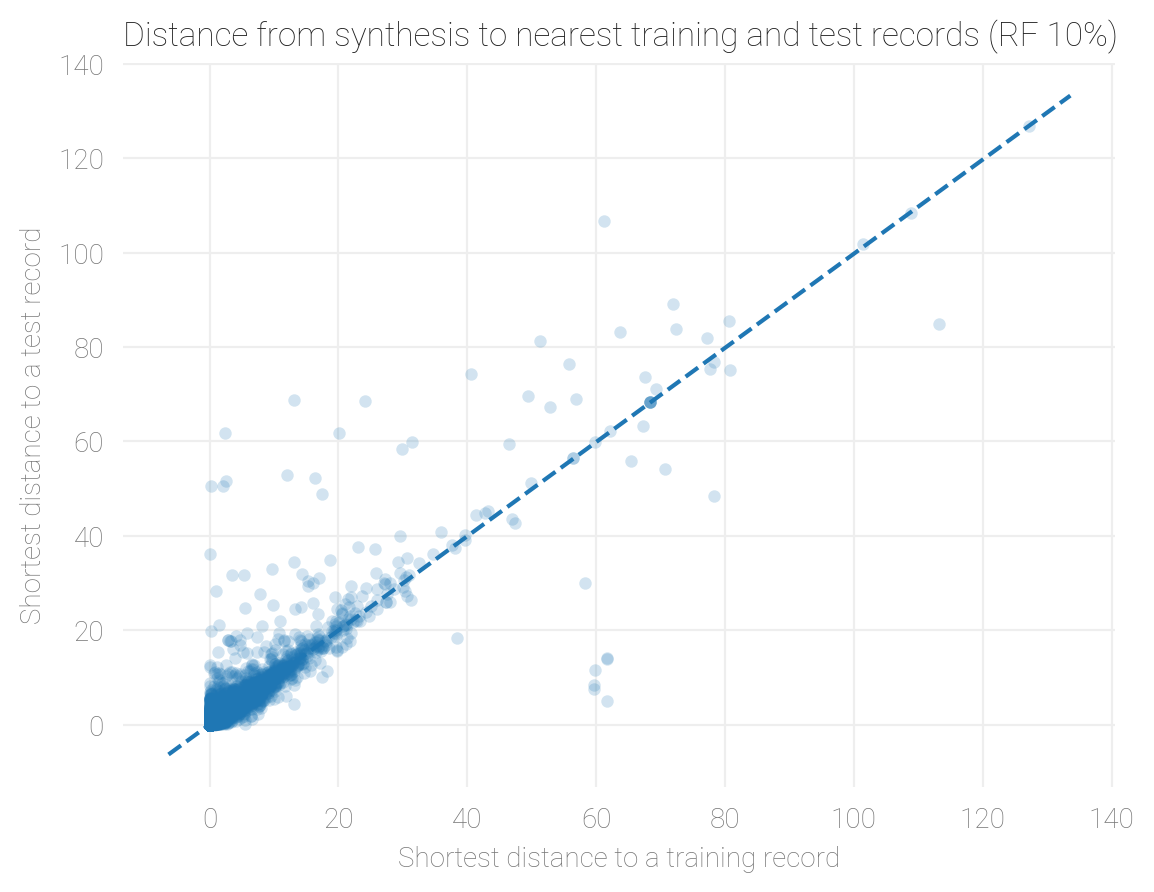

In [30]:
ax = nearest.plot.scatter('train_dist', 'test_dist', alpha=0.2, linewidths=0.0)
# 45-degree line.
ax.plot(ax.get_xlim(), ax.get_ylim(), ls='--')
# plt.xscale('log')
# plt.yscale('log')
sns.despine(left=True, bottom=True)
ax.grid(color='#eeeeee')
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.set(xlabel='Shortest distance to a training record',
       ylabel='Shortest distance to a test record')
plt.title('Distance from synthesis to nearest training and test records (RF 10%)',
          loc='left')
plt.show()

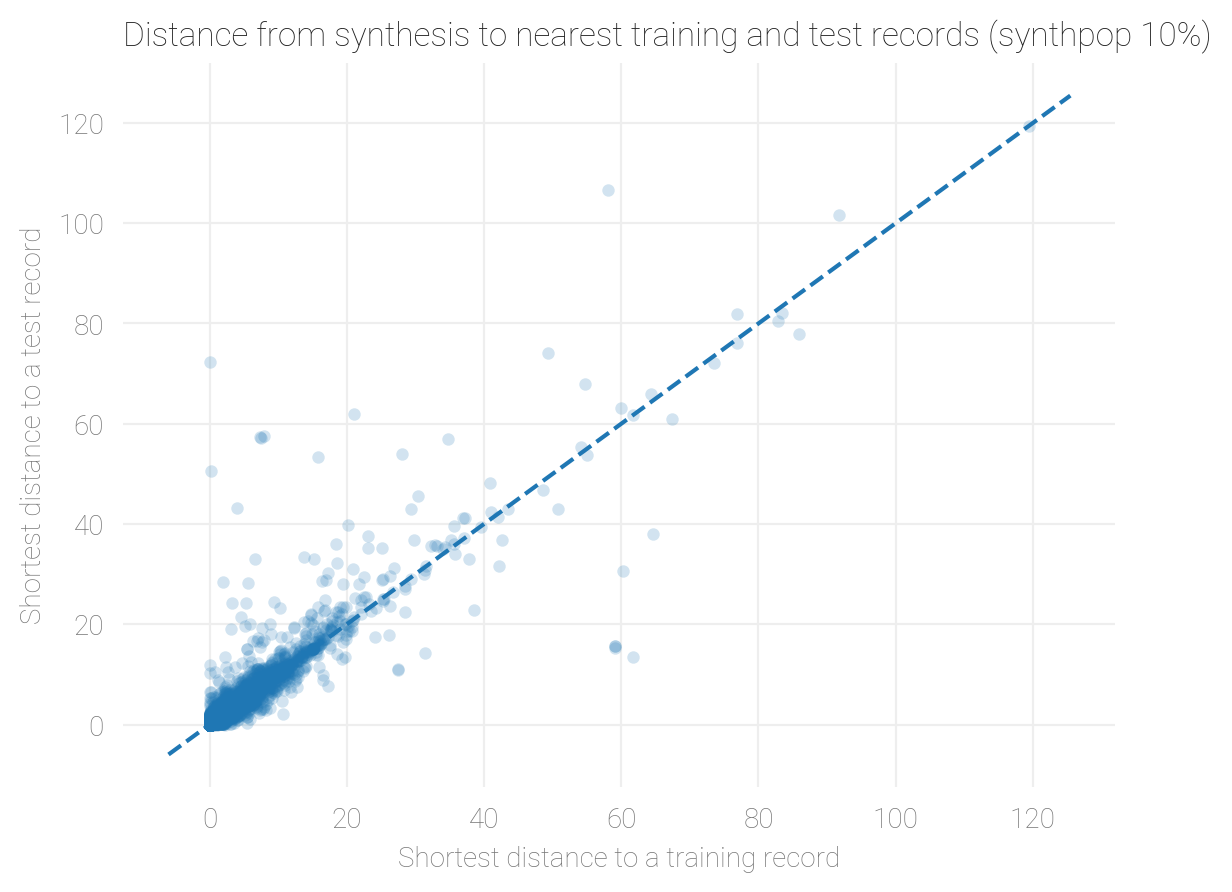

In [31]:
ax = nearest2.plot.scatter('train_dist', 'test_dist', alpha=0.2, linewidths=0.0)
# 45-degree line.
ax.plot(ax.get_xlim(), ax.get_ylim(), ls='--')
# plt.xscale('log')
# plt.yscale('log')
sns.despine(left=True, bottom=True)
ax.grid(color='#eeeeee')
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.set(xlabel='Shortest distance to a training record',
       ylabel='Shortest distance to a test record')
plt.title('Distance from synthesis to nearest training and test records (synthpop 10%)',
          loc='left')
plt.show()

### CDFs of distances

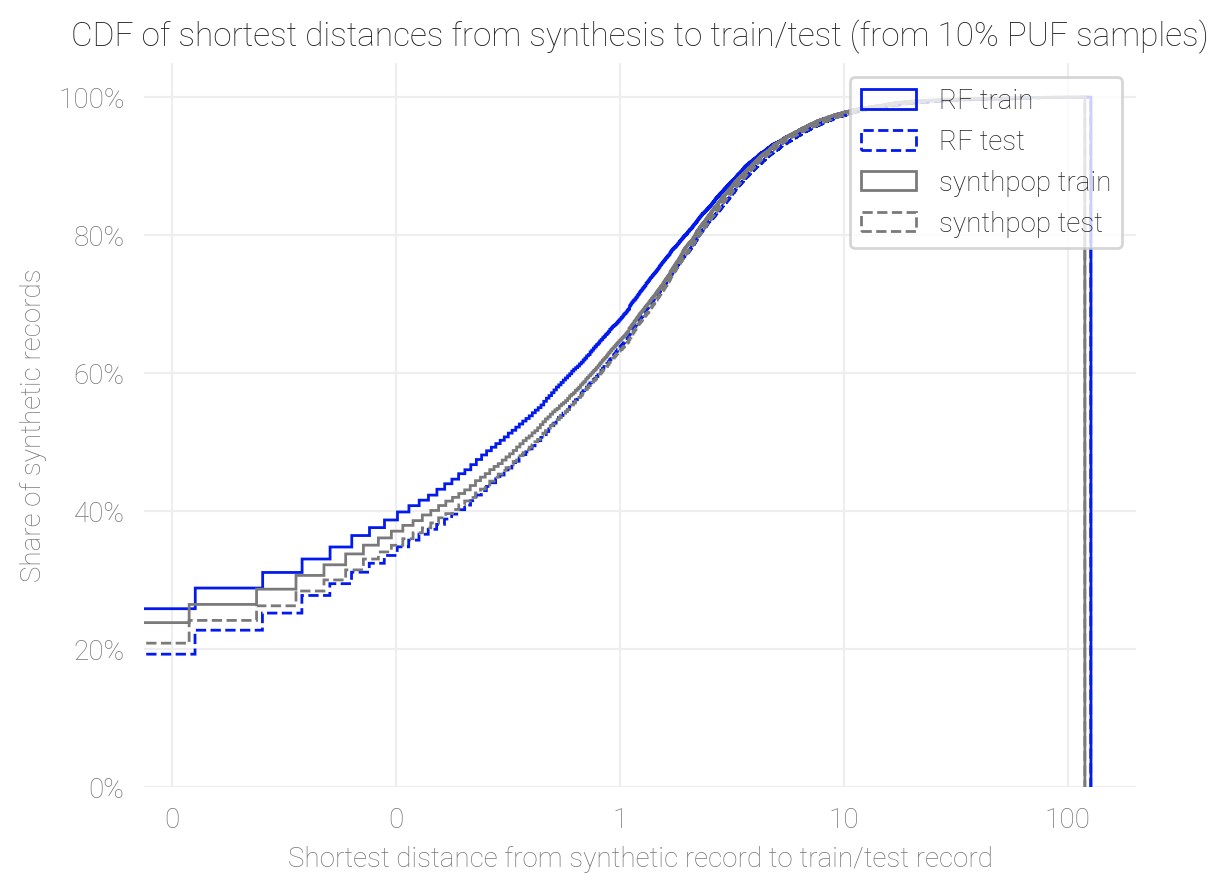

In [39]:
# Plot the four series.
ax = nearest.train_dist.hist(cumulative=True, density=1, bins=10000, color='#021aee', histtype='step')
nearest.test_dist.hist(cumulative=True, density=1, bins=10000, histtype='step', color='#021aee', ls='--')
nearest2.train_dist.hist(cumulative=True, density=1, bins=10000, histtype='step', color='#7a7a7a')
nearest2.test_dist.hist(cumulative=True, density=1, bins=10000, histtype='step', color='#7a7a7a', ls='--')
# Formatting.
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda y, _: '{:.0%}'.format(y)))
ax.grid(color='#eeeeee')
sns.despine(left=True, bottom=True)
plt.xscale('log')
ax.xaxis.set_major_formatter(ScalarFormatter())
plt.legend(['RF train', 'RF test', 'synthpop train', 'synthpop test'])
ax.set(xlabel='Shortest distance from synthetic record to train/test record',
       ylabel='Share of synthetic records')
plt.title('CDF of shortest distances from synthesis to train/test (from 10% PUF samples)')
plt.show()

### Exact matches

In [26]:
print((nearest.train_dist == 0).mean())

print((nearest2.train_dist == 0).mean())

print((nearest.test_dist == 0).mean())

print((nearest2.test_dist == 0).mean())

0.13548662840395653
0.07724719101123595
0.0375503724508487
0.04787493893502687
